# Data import fonction
# Select the data based on area and quality
# Smport the data --> extract spikes times and spike rate per cell
# Calculate binned spike time series

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
### get area from clusters idx
def get_area_from_clusters(cluster_idx,all_data_path, selected_recordings):


    cluster_peakChannel =  np.load(all_data_path +'/'+selected_recordings+'/'+'clusters.peakChannel.npy')
    individualchannel_location = pd.read_csv(all_data_path +'/'+selected_recordings+'/'+'channels.brainLocation.tsv', sep='\t')
    individualchannel_location = individualchannel_location.allen_ontology;
    
    channellocation = cluster_peakChannel[cluster_idx]
    area = np.array(individualchannel_location[channellocation])
    return area


### get the clean clusters
def get_clean_clusters(cluster_quality):
    ## cluster indices from "good spikes" from the 'clusters' objects 
    print('number of clusters in cluster_idx => '+str(len(cluster_quality)))
    
    # 0 = noise (these are already excluded and don't appear in this dataset at all); 
    # 1 = MUA (i.e. presumed to contain spikes from multiple neurons; 
    # these are not analyzed in any analyses in the paper); 
    # 2 = Good (manually labeled); 3 = Unsorted. 
    # In this dataset 'Good' was applied in a few but not all datasets to included neurons, 
    # so in general the neurons with _phy_annotation>=2 are the ones that should be included.
    clusters_idx = np.arange(len(cluster_quality))
    cluster_good_where = np.where(cluster_quality>=2);
    cluster_good_where = cluster_good_where[0]
    good_and_unsorted_clusters = clusters_idx[cluster_good_where]
    print('number of "good" and "unsorted" clusters in cluster_idx => '+ str(len(good_and_unsorted_clusters)))
    
    return good_and_unsorted_clusters


def get_population_timeseries_matrices(listsofareas, labels, binning_resolution_sec=1, 
                                       all_data_path='/Users/jean/git/steinmetz-et-al-2019/data', 
                                       selected_recordings= 'Richards_2017-10-31'):
#     '''
#     # inputs --> lists of area ; N list of areas as many as you want (see example below)
#     # returns --> All_binned_timeseries as N arrays in one array
    
    
#     ## how to use it 
#     ## define cluster of brain areas
#     mid_brain_circuits=['SCs','SCm','MRN','APN','PAG','ZI']
#     frontal_circuits=['MOs','PL','ILA','ORB','MOp','SSp']
#     population_matrices = get_population_timeseries_matrices([mid_brain_circuits,
#                                                                 frontal_circuits], 
#                                                              binningresol_sec = 1, 
#                                                              all_data_path='/Users/jean/git/steinmetz-et-al-2019/data', 
#                                                              selected_recordings= 'Richards_2017-10-31')
#                                                              '''
                                                             

    ## identify brain areas recorded by individual channels
    output = {}
    individualchannel_location = pd.read_csv(all_data_path +'/'+selected_recordings+'/'+'channels.brainLocation.tsv', sep='\t')
    individualchannel_location = individualchannel_location.allen_ontology;
    individualchannel_location = np.array(individualchannel_location)
    print('recording along '+ str(len(individualchannel_location)) +' channels')
    print('brain areas recorded in that animal')
    print(np.unique(individualchannel_location))
    
    ## get good_and_unsorted_clusters
    cluster_quality = np.load(all_data_path +'/'+selected_recordings+'/'+'clusters._phy_annotation.npy')
    good_and_unsorted_clusters = get_clean_clusters(cluster_quality)
    
    ## area of good_and_unsorted_clusters
    cluster_area = []
    for q in good_and_unsorted_clusters:
        that_cluster_area = get_area_from_clusters(q,all_data_path, selected_recordings)
        cluster_area.append(that_cluster_area[0])
#     print(str(len(cluster_area)))
          
    ## spikes and cluster idx from the 'spikes' object
    spiketimes = np.load(all_data_path +'/'+selected_recordings+'/'+'spikes.times.npy')
    spikeclusters = np.load(all_data_path +'/'+selected_recordings+'/'+'spikes.clusters.npy')
    recordinglength_sec = np.max(spiketimes) - np.min(spiketimes)
    print(recordinglength_sec)
    ## to check if it corresponds to clusters class
    ## the numbers in there match raws of the cluster objects (see below)
    uniquespikeclusters = np.unique(spikeclusters)
    print('number of clusters in spikeclusters => '+str(len(uniquespikeclusters)))
    
    # ploting the 5000 nth spikes, picked from all the clusters
    '''
    firstspiketoplot = 0
    numberofspikestoplot = 5000
    idtoplot = np.arange(firstspiketoplot, firstspiketoplot+numberofspikestoplot)
    plt.plot(spiketimes[idtoplot], spikeclusters[idtoplot], '.')
    plt.xlabel('time sec')
    plt.ylabel('cluster id')
    plt.title('plot all unsorted and unselected spikes - are there two neuropixel probes in that animal?')
    '''

    ## returns as many population matrices as len(listsofareas)
    ## each population matrix is a N cells X ~ duration/binningresol_sec array
    #All_binned_timeseries = []
    ##All_spiketimes = []
    #All_average_spikerate_Hz = []
    #All_clusters=[]
    #All_Areas=[]
    for brainareaidx in np.arange(len(listsofareas)):
        
        BrainArea = listsofareas[brainareaidx]

        ### find clean units from the right areas
        logical_goodclustersinrightarea = np.zeros(len(cluster_area)) 
        for ThatRegOIfInt in BrainArea:
            for ar in np.arange(len(cluster_area)):
                if cluster_area[ar] == ThatRegOIfInt:
                    logical_goodclustersinrightarea[ar]=1
    
        clean_Clusters_InTheRightArea = np.where(logical_goodclustersinrightarea==1)[0]
        print(clean_Clusters_InTheRightArea)
        
#         print(type(logical_goodclustersinrightarea))
#         print(type(cluster_area))
#         print(cluster_area)
        cluster_area_array = np.array(cluster_area)
        clean_Clusters_InTheRightArea_area = cluster_area_array[logical_goodclustersinrightarea==1]
        print('Number of clean clusters in '+labels[brainareaidx]+ ' => '+str(len(clean_Clusters_InTheRightArea)))
    
        # timeseries
        #binning_resolution_sec = 20 #sec 
        numberofbins = int(round(np.max(spiketimes)/binning_resolution_sec)); #
        #print(numberofbins)
        bins = np.linspace(0, int(np.max(spiketimes)+1), numberofbins)
        #print(np.max(spiketimes))
        #bins.shape
        FigRaster = plt.figure() # initializing figure rasters
        FigRasterAx = FigRaster.add_axes([0.1, 0.1, 1.8, 2])
        ## preallocating
        binned_timeseries = np.zeros((len(clean_Clusters_InTheRightArea), len(bins)-1))
        average_spikerate_Hz = np.zeros((len(clean_Clusters_InTheRightArea),1))
        #binned_timeseries = np.empty(len(clean_Clusters_InTheRightArea), dtype=object)
        allspiketimes_sec = np.empty(len(clean_Clusters_InTheRightArea), dtype=object)
        #average_spikerate_Hz = np.empty(len(clean_Clusters_InTheRightArea), dtype=object)
        ## iteratively selecting spikes from distinct cluster and generating an array of N arrays for N cells
        for thatspike in np.arange(len(clean_Clusters_InTheRightArea)):
            #print(clean_Clusters_InTheRightArea[thatspike])
            #length(clean_Clusters_InTheRightArea[thatspike])
            those_spike_indices = (spikeclusters == clean_Clusters_InTheRightArea[thatspike])
            # calculate spike rate --> number of spikes / by length of recording
            average_spikerate_Hz[thatspike] = np.sum(those_spike_indices)/recordinglength_sec
#             print('rate = '+str(average_spikerate_Hz[thatspike])+' Hz')
            allspiketimes_sec[thatspike] = spiketimes[those_spike_indices==1];
            #print(spiketimes[those_spike_indices])
            FigRasterAx.eventplot(spiketimes[those_spike_indices], lineoffsets=thatspike+1)

            # building histogram --> 20 ms binning of the data
            # starting at time = 0 to max(spiketimes)
            binned_timeseries[thatspike], bin_edges = np.histogram(spiketimes[those_spike_indices], bins, density=True) 


        bin_center = bin_edges[:-1] + (np.min(np.diff(bin_edges))/2)

        FigRasterAx.set_ylabel('selected cells')
        FigRasterAx.set_xlabel('time (sec)')
        FigRasterAx.set_title(labels[brainareaidx]+' - rasters of selected cells')
        FigRasterAx.axis('tight')

        ## visualising time series color plot
        #FigTimeSeries = plt.figure() # initializing figure TimeSeries
        FigTimeSeriesAx = FigRaster.add_axes([2.1, .1, 1.8, 2])
        MaxOfRows = np.max(binned_timeseries, axis=1);
        Normalizationfordisplay = binned_timeseries/MaxOfRows[:,None]
        FigTimeSeriesAx.imshow(Normalizationfordisplay)
        FigTimeSeriesAx.axis('tight')
        FigTimeSeriesAx.set_ylabel('selected cells')
        FigTimeSeriesAx.set_xlabel('time (sec)')
        FigTimeSeriesAx.set_title(labels[brainareaidx]+' - '+str(binning_resolution_sec)+'sec binned time series')
        FigTimeSeriesAx.invert_yaxis()
     
        thatdata_in_dict = {}
        thatdata_in_dict['clusters'] = clean_Clusters_InTheRightArea
        thatdata_in_dict['area'] = clean_Clusters_InTheRightArea_area
        thatdata_in_dict['all_binned_timeseries'] = binned_timeseries
        thatdata_in_dict['bin_sec'] = binning_resolution_sec
        thatdata_in_dict['all_spike_times_sec']=allspiketimes_sec
        thatdata_in_dict['spike_rate_Hz']=average_spikerate_Hz
        
        
        output[labels[brainareaidx]] = thatdata_in_dict;
           
    return output

# run the function for selected areas/group of areas

recording along 748 channels
brain areas recorded in that animal
['MOs' 'MRN' 'OLF' 'ORB' 'PAG' 'RSP' 'SCm' 'SCs' 'root']
number of clusters in cluster_idx => 778
number of "good" and "unsorted" clusters in cluster_idx => 522
2968.2751042478308
number of clusters in spikeclusters => 778
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 17

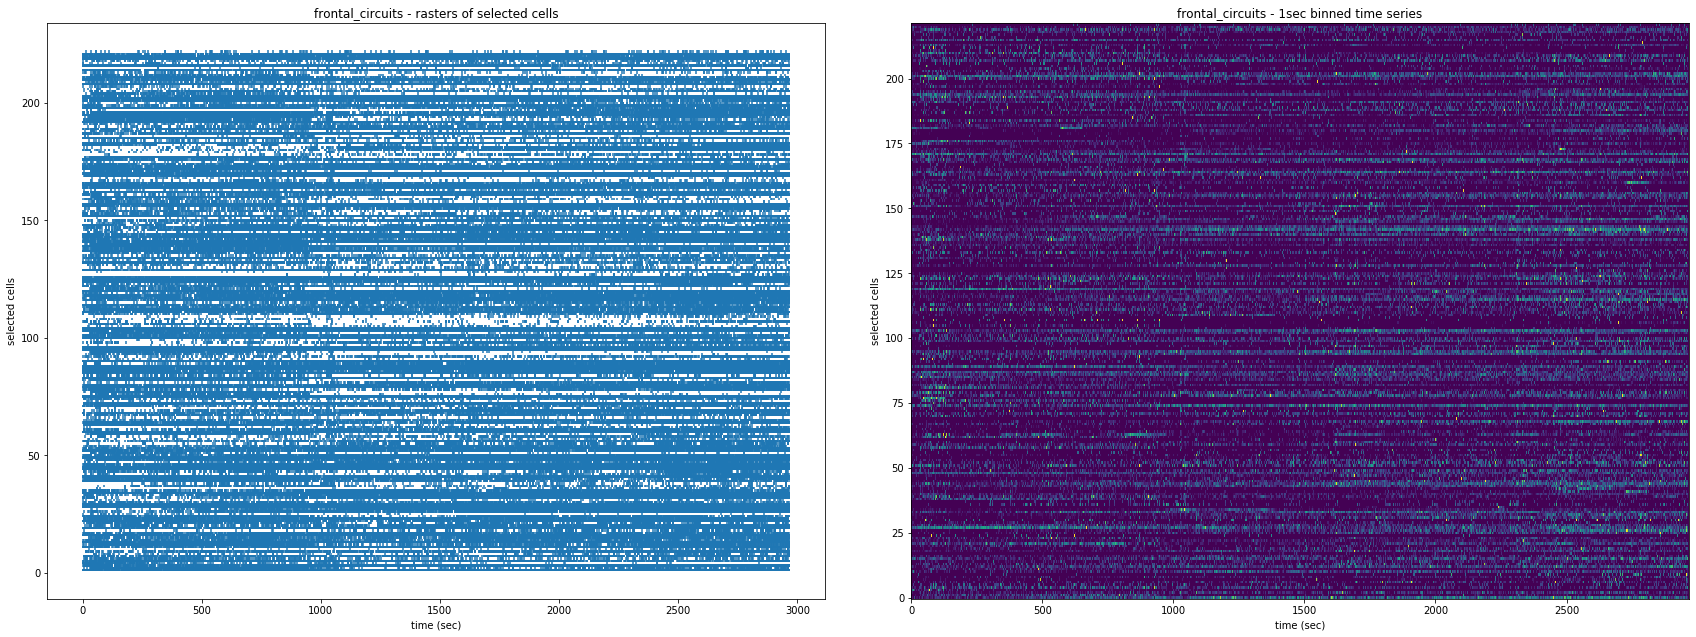

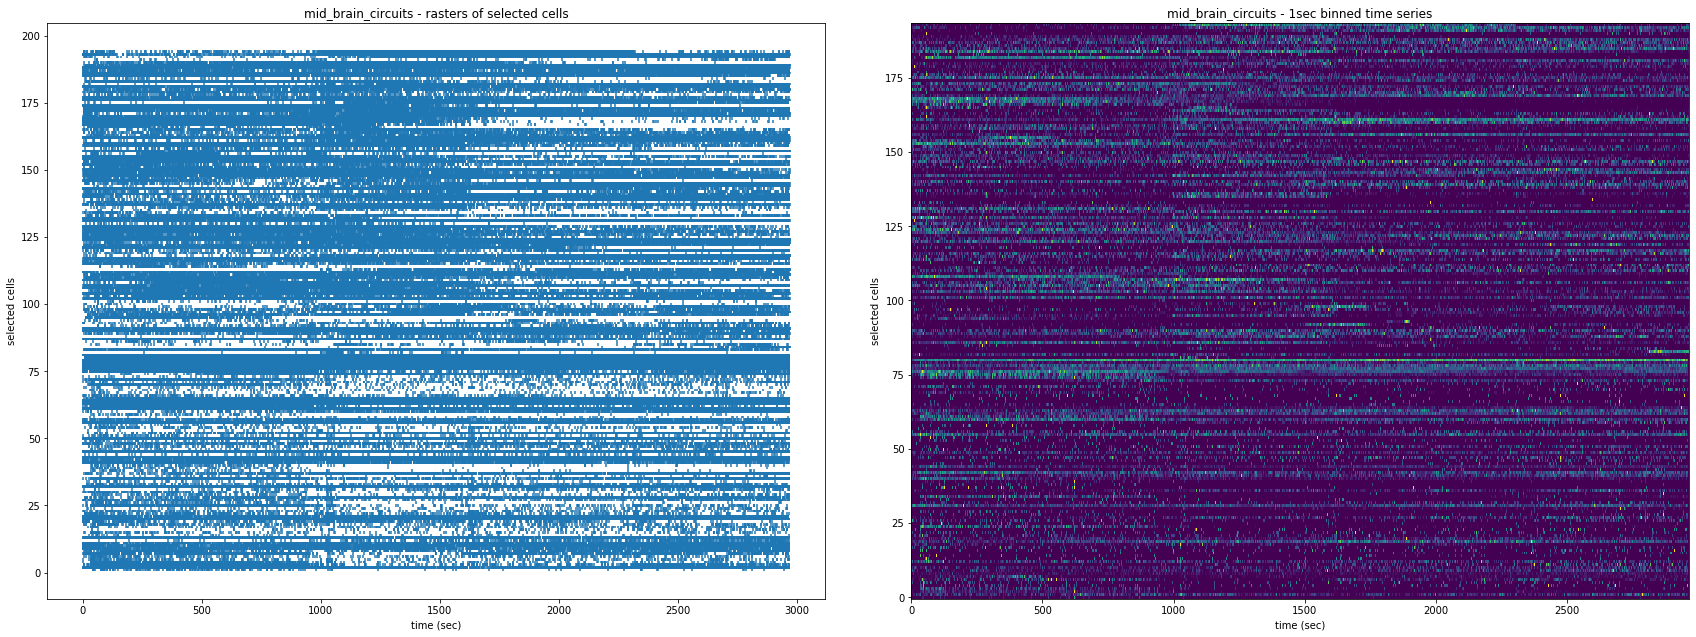

In [34]:
####### 
# mid_brain_circuits=['PAG']
# frontal_circuits=['MOs']
# all_data_path='/Users/jean/git/steinmetz-et-al-2019/data'
# selected_recordings= 'Richards_2017-10-31'
mid_brain_circuits=['SCs','SCm','MRN','APN','PAG','ZI']
frontal_circuits=['MOs','PL','ILA','ORB','MOp','SSp']
thatlabel = ['frontal_circuits', 'mid_brain_circuits']
OUT = get_population_timeseries_matrices([frontal_circuits, mid_brain_circuits],\
                                         labels=thatlabel, binning_resolution_sec = 1,\
                                         all_data_path='/Users/jean/git/steinmetz-et-al-2019/data', \
                                         selected_recordings= 'Richards_2017-10-31')
print(OUT.keys())
print(OUT['frontal_circuits'].keys())
print(OUT['mid_brain_circuits'].keys())

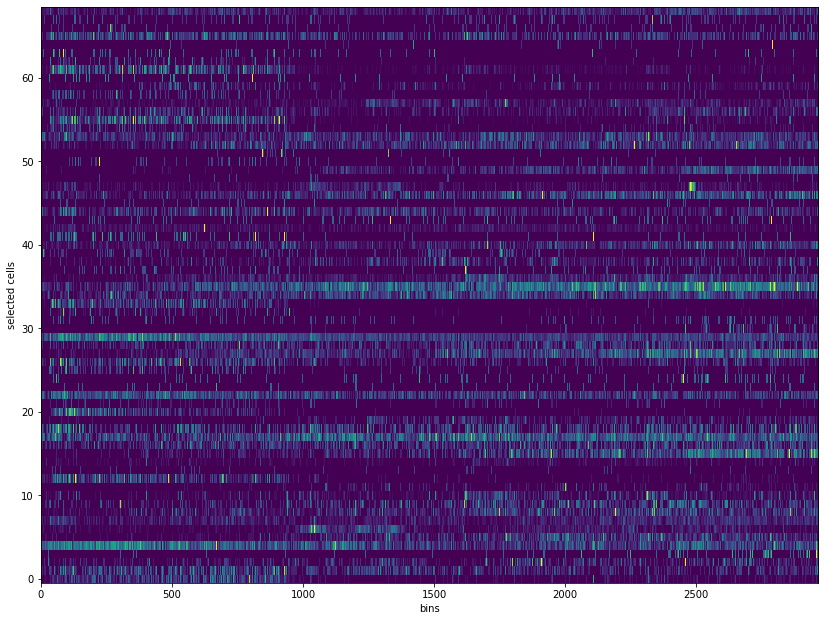

In [3]:
MyMat= OUT['frontal_circuits']['all_binned_timeseries']
FigTimeSeries = plt.figure() # initializing figure TimeSeries
FigTimeSeriesAx = FigTimeSeries.add_axes([2.1, .1, 1.8, 2])
MaxOfRows = np.max(MyMat, axis=1);
Normalizationfordisplay = MyMat/MaxOfRows[:,None]
FigTimeSeriesAx.imshow(Normalizationfordisplay)
FigTimeSeriesAx.axis('tight')
FigTimeSeriesAx.set_ylabel('selected cells')
FigTimeSeriesAx.set_xlabel('bins')
FigTimeSeriesAx.invert_yaxis()

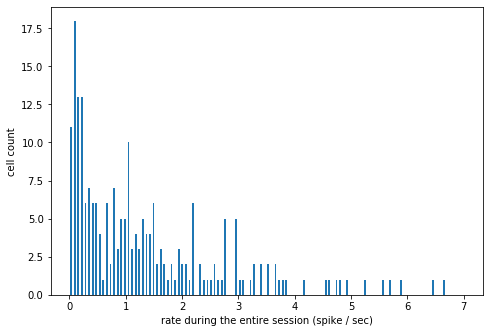

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log


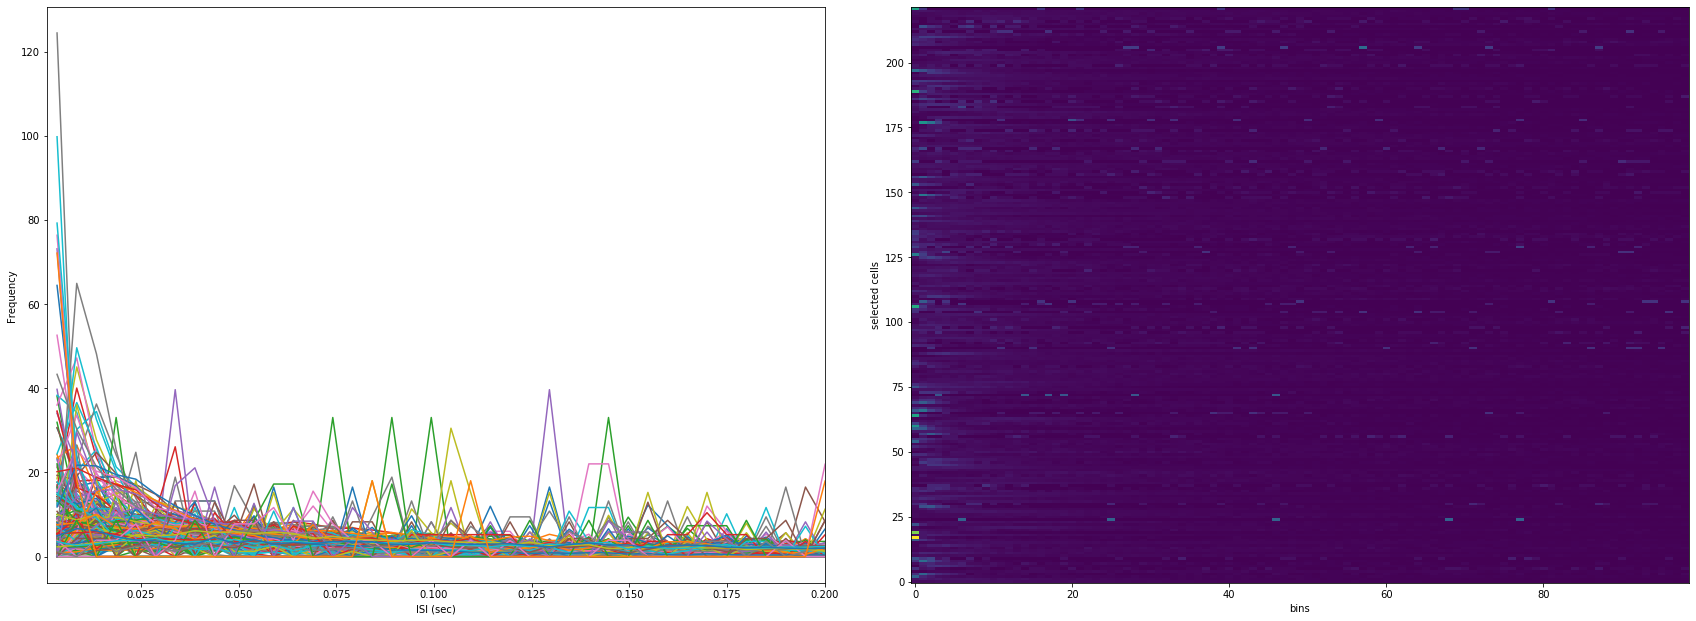

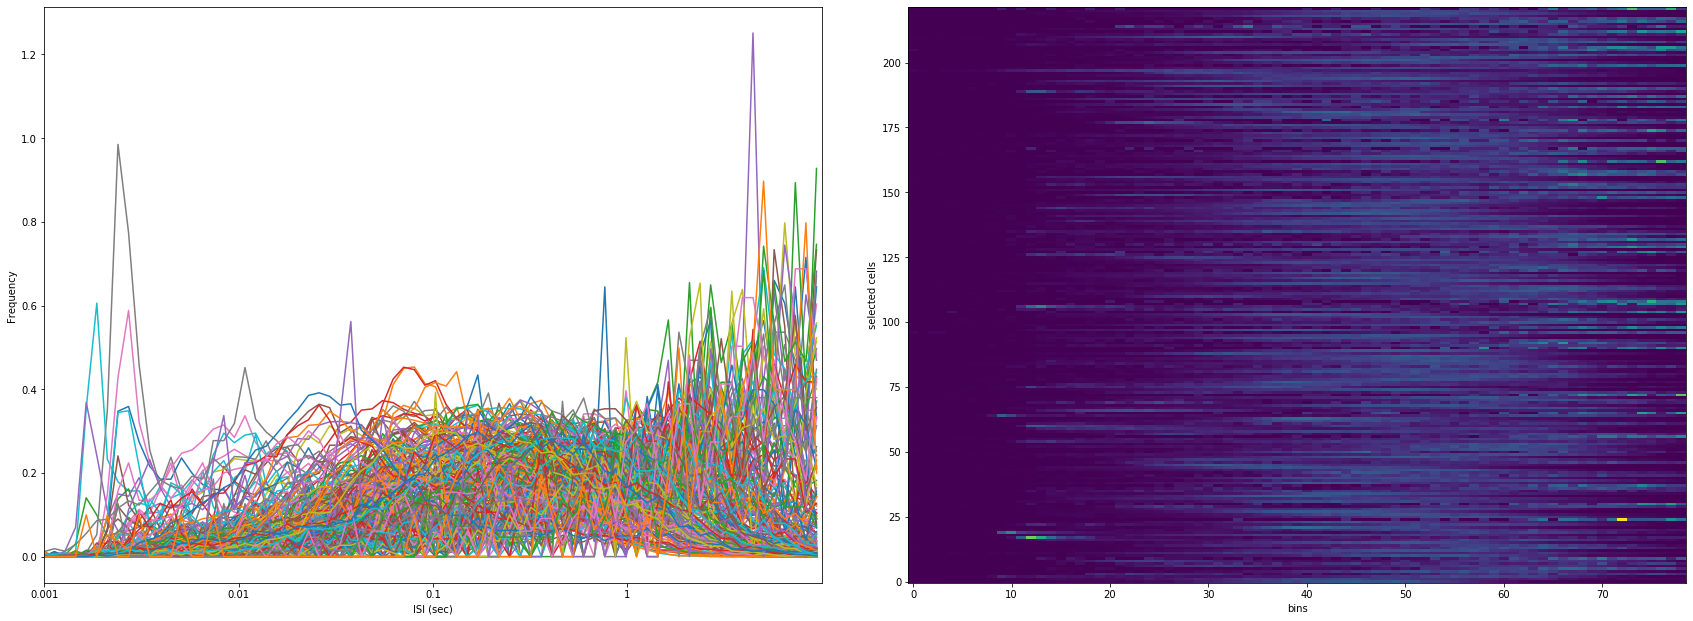

In [30]:
AllspkTime_sec = OUT['frontal_circuits']['all_spike_times_sec']
AllSpikes_Rate_Hz = OUT['frontal_circuits']['spike_rate_Hz']
maxRate = np.max(AllSpikes_Rate_Hz)

## spike rate histogram
numberofbins = int(len(AllSpikes_Rate_Hz)/2) ## number of cells divided by two

binning_spikerate_Hz = np.linspace(0, int(maxRate+1), numberofbins)

counts, _ = np.histogram(AllSpikes_Rate_Hz, bins=binning_spikerate_Hz)
plotPoints = binning_spikerate_Hz[:-1] + (np.min(np.diff(binning_spikerate_Hz))/2)
#print(np.min(np.diff(binning_spikerate_Hz))/2)

#print(AllSpikes_Rate_Hz.shape)
# print(counts)
# print(plotPoints)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(plotPoints,counts, align='center', alpha=1, width= np.min(plotPoints))
ax.set_xlabel('rate during the entire session (spike / sec)')
ax.set_ylabel('cell count')
ax.axis('tight')
plt.show()


#     freq, binEdges = np.histogram(logISI[i][0:logISI[i].count()],weights=w, bins=log_binning)
#     #Note: freq is the values of the histogram : 59 of them, one for each bin
#     #binEdges is the edges of the bins, 60 of them since each bin has 2 sides
#     logISI_hist[i] = freq
#     #Let's create a proper point for each value: the center of the bin it represents
#     plotPoints = (binEdges[1:]+binEdges[:-1])/2
   

Index = np.arange(len(AllSpikes_Rate_Hz))
# print(Index)
log_binning = np.linspace(np.log(0.0005),np.log(10), 80) #This will be the bins to model the ISI distribution for the graph
logISI_hist = np.zeros((len(Index), len(log_binning)-1))
logISI_hist_bins = np.zeros((len(Index), len(log_binning)-1))

binning = np.linspace(0.001,0.5, 100) #This will be the bins to model the ISI distribution for the graph
ISI_hist = np.zeros((len(Index), len(binning)-1))
ISI_hist_bins = np.zeros((len(Index), len(binning)-1))

# print(logISI.shape)
for I in Index:
    ISIs = np.diff(AllspkTime_sec[I])
    hist, bin_edges = np.histogram(ISIs, bins=binning ,density=True )
    ISI_hist[I] = hist
    ISI_hist_bins[I] = bin_edges[:-1] + (np.min ( np.diff(bin_edges) ))/2

    logISIs = np.log(ISIs)
    log_hist, log_bin_edges = np.histogram(logISIs, bins=log_binning ,density=True )
    logISI_hist[I] = log_hist
    logISI_hist_bins[I] = log_bin_edges[:-1] + (np.min ( np.diff(log_bin_edges) ))/2
       
Fig_histograms = plt.figure() 
axISI = Fig_histograms.add_axes([0.1, .1, 1.8, 2])
axISI.plot(ISI_hist_bins.T, ISI_hist.T,)
axISI.set_xlabel('ISI (sec)')
axISI.set_ylabel('Frequency')
axISI.set_xlim(0.001,0.2)
Ax = Fig_histograms.add_axes([2.1, .1, 1.8, 2])
Ax.imshow(ISI_hist)
Ax.axis('tight')
Ax.set_ylabel('selected cells')
Ax.set_xlabel('bins')
Ax.invert_yaxis()
# print(logISI_hist)


Fig_histograms = plt.figure() 
axISI = Fig_histograms.add_axes([0.1, 2.1, 1.8, 2])
axISI.plot(logISI_hist_bins.T, logISI_hist.T,)
axISI.set_xlabel('ISI (sec)')
axISI.set_ylabel('Frequency')
axISI.set_xlim(np.log(0.001), np.log(10))
axISI.set_xticks([np.log(0.001), np.log(0.01), np.log(0.1), np.log(1)])
axISI.set_xticklabels([0.001, 0.01, 0.1, 1])

Ax = Fig_histograms.add_axes([2.1, 2.1, 1.8, 2])
Ax.imshow(logISI_hist)
Ax.axis('tight')
Ax.set_ylabel('selected cells')
Ax.set_xlabel('bins')
Ax.invert_yaxis()
# print(logISI_hist)



In [ ]:
logISI = pd.DataFrame(data=None, columns= Index, dtype = float)
for I in Index:
    logISI[i] = np.diff(AllspkTime_sec[I])
    

    
   

In [ ]:
 
    
#Computing the log of the ISIs for each cell
logISI = pd.DataFrame(data=None, columns= Index, dtype = float)

for i in Index:
    temp = pd.Series(np.log(cells_spike_times.at[i,'ISIs'][c]) for c in range(1,len(cells_spike_times.at[i,'ISIs'])))
    if temp.size > logISI[i].size:
        logISI = logISI.reindex(temp.index)
    logISI[i] = temp


#We need to keep the values of the histogram somewhere:
logISI_hist= pd.DataFrame(data=None,dtype=float, columns=Index)
autoCorr = pd.DataFrame(data=None, dtype=float,columns=Index)

fig1, axISI = plt.subplots() #Plot for the ISI distrib
axISI.set_title('log representation of the ISIs for all the cells')

fig2, axAcorr = plt.subplots() #Plot for the autocorrelograms
axAcorr.set_title('Autocorrelation plot for the spike times of all the cells')

for i in Index:
    w = np.ones(logISI[i].count())/logISI[i].count()
    freq, binEdges = np.histogram(logISI[i][0:logISI[i].count()],weights=w, bins=log_binning)
    #Note: freq is the values of the histogram : 59 of them, one for each bin
    #binEdges is the edges of the bins, 60 of them since each bin has 2 sides
    logISI_hist[i] = freq
    #Let's create a proper point for each value: the center of the bin it represents
    plotPoints = (binEdges[1:]+binEdges[:-1])/2
    
    
    #Calculate the autocorrelation values
    binningAcorr = np.arange(min(cells_spike_times.at[i,'Spike_times']), max(cells_spike_times.at[i,'Spike_times']+0.001),0.001)
    binnedSpikeTimes = np.histogram(cells_spike_times.at[i,'Spike_times'], bins= binningAcorr)
    lags_sec = np.linspace(0.001,0.020,20)
    autoCorr[i] = acf(binnedSpikeTimes[0],nlags=21,fft=False)[1:21]
    
    #Plot the two lines
    axISI.plot(plotPoints, freq, linewidth=0.5, color='black')
    
    axAcorr.plot(lags_sec, acf(binnedSpikeTimes[0],nlags=21,fft=False)[1:21], linewidth = 0.5, color='black')
    


[Text(0, 0, 'trial_start'),
 Text(0, 0, 'trial_end'),
 Text(0, 0, 'passive visual'),
 Text(0, 0, 'passiveValveClick'),
 Text(0, 0, 'passiveBeeps'),
 Text(0, 0, 'passiveWhiteNoise'),
 Text(0, 0, 'spontaneous_intervals_begin'),
 Text(0, 0, 'spontaneous_intervals_end')]

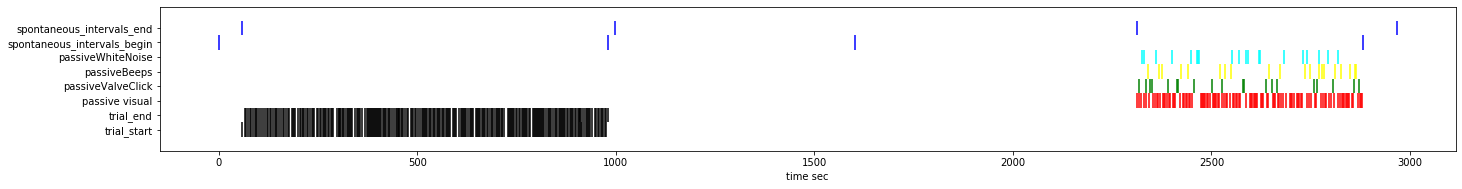

In [92]:
import numpy as np
import matplotlib.pyplot as plt

all_data_path='/Users/jean/git/steinmetz-et-al-2019/data'
selected_recordings= 'Richards_2017-10-31'
data_path = all_data_path+'/'+selected_recordings

## SPONTANEOUS INTERVALS
spontaneous_intervals = np.load(data_path+'/'+'spontaneous.intervals.npy')

### TRIALS
trials_intervals = np.load(data_path+'/'+'trials.intervals.npy') # in seconds
trials_visual_time = np.load(data_path+'/'+'trials.visualStim_times.npy')
trials_gocue_times = np.load(data_path+'/'+'trials.goCue_times.npy')
trials_response_time = np.load(data_path+'/'+'trials.response_times.npy')
# trials_feedback_time = np.load(data_path+'/'+'feedback_times.npy')
# trials_feedbackType = np.load(data_path+'/'+'feedbackType.npy')
#trials_response_choice = np.load(data_path+'/'+'trials.response_choice.npy') # -1 left, 1, right, 0 no response


## RECEPTIVE FIELD MAPPING
sparseNoise_time_sec = np.load(data_path+'/'+'sparseNoise.times.npy')
sparseNoise_positions = np.load(data_path+'/'+'sparseNoise.positions.npy')
### PASSIVE VISUAL STIMS
passiveVisual_time_sec = np.load(data_path+'/'+'passiveVisual.times.npy')
# contrastLeft.
# contrastRight.
passiveValveClick_time_sec = np.load(data_path+'/'+'passiveValveClick.times.npy')
passiveBeeps_time_sec = np.load(data_path+'/'+'passiveBeeps.times.npy')
passiveWhiteNoise_time_sec = np.load(data_path+'/'+'passiveWhiteNoise.times.npy')
behavfig = plt.figure() 
AX = behavfig.add_axes([0, 0, 3,0.5])
AX.eventplot(trials_intervals[:,0], colors='black', lineoffsets=-1)
AX.eventplot(trials_intervals[:,1], colors='black', lineoffsets=0)
AX.eventplot(passiveVisual_time_sec[:,0], colors='red', lineoffsets=1)
AX.eventplot(passiveValveClick_time_sec[:,0], colors='green', lineoffsets=2)
AX.eventplot(passiveBeeps_time_sec[:,0], colors='yellow', lineoffsets=3)
AX.eventplot(passiveWhiteNoise_time_sec[:,0], colors='cyan', lineoffsets=4)
AX.eventplot(spontaneous_intervals[:,0], colors='blue', lineoffsets=5) ## begining of spontaneous intervals
AX.eventplot(spontaneous_intervals[:,1], colors='blue', lineoffsets=6) ## end of spontaneous intervals
AX.set_xlabel('time sec')
AX.axis('tight')
AX.set_yticks([-1,0,1,2,3,4,5,6])
AX.set_yticklabels(['trial_start', 'trial_end', 'passive visual',\
                       'passiveValveClick', 'passiveBeeps', 'passiveWhiteNoise',\
                      'spontaneous_intervals_begin', 'spontaneous_intervals_end'])
# AX.set_xlim(300, 700)